## Dependencias

In [102]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()

## Lectura de datos

In [103]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/fraud_oracle.csv'
df = pd.read_csv(ruta)
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [104]:
df.shape

(15420, 33)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

## Conversión de columnas

In [106]:
X = df.copy()

In [107]:
for v in X.columns:
    if X[v].dtype=='object':
        for a,b in zip(list(X[v].unique()),range(0,len(list(X[v].unique()))+1)):
            X.loc[X[v]==a,v]=b
        X[v] = pd.to_numeric(X[v])

## Definición de variables

In [108]:
X.insert(0,'id',X.index)

In [109]:
um = ['id']
vart = ['FraudFound_P']
varc = [v for v in X.columns if v not in um and v not in vart]

## Análisis exploratorio

### Balanceo de muestra

In [110]:
X['FraudFound_P'].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

In [111]:
X = pd.concat([d.sample(923).reset_index(drop=True) for _,d in X.groupby('FraudFound_P')], ignore_index=True)

In [112]:
X['FraudFound_P'].value_counts()

0    923
1    923
Name: FraudFound_P, dtype: int64

### Valores nulos

In [113]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.0
Month,0.0
WeekOfMonth,0.0
DayOfWeek,0.0
Make,0.0
AccidentArea,0.0
DayOfWeekClaimed,0.0
MonthClaimed,0.0
WeekOfMonthClaimed,0.0
Sex,0.0


### Varianza nula

In [114]:
vt = VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [115]:
fuera = [a for a,b in zip(varc,vt.get_support()) if not b]
fuera

[]

### Selección de variables con mejor poder predictivo

In [116]:
sk = SelectKBest(k=len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=32)

In [117]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [118]:
sk = SelectKBest(k=3)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=3)

In [119]:
best = [a for a,b in zip(varc,sk.get_support()) if b]
best

['Fault', 'VehicleCategory', 'BasePolicy']

### Valores extremos

array([[<AxesSubplot:title={'center':'Fault'}>,
        <AxesSubplot:title={'center':'VehicleCategory'}>],
       [<AxesSubplot:title={'center':'BasePolicy'}>, <AxesSubplot:>]],
      dtype=object)

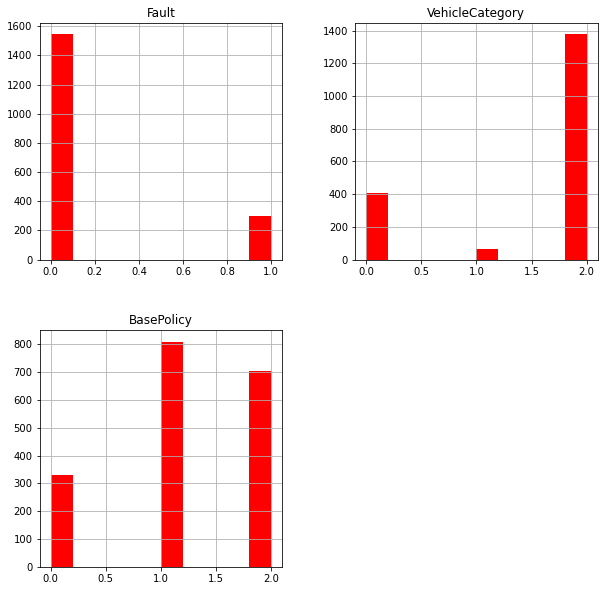

In [120]:
X[best].hist(figsize=(10,10),color='red')

In [121]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    1.0
Name: ex_, dtype: float64

In [122]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'Fault'}>,
        <AxesSubplot:title={'center':'VehicleCategory'}>],
       [<AxesSubplot:title={'center':'BasePolicy'}>, <AxesSubplot:>]],
      dtype=object)

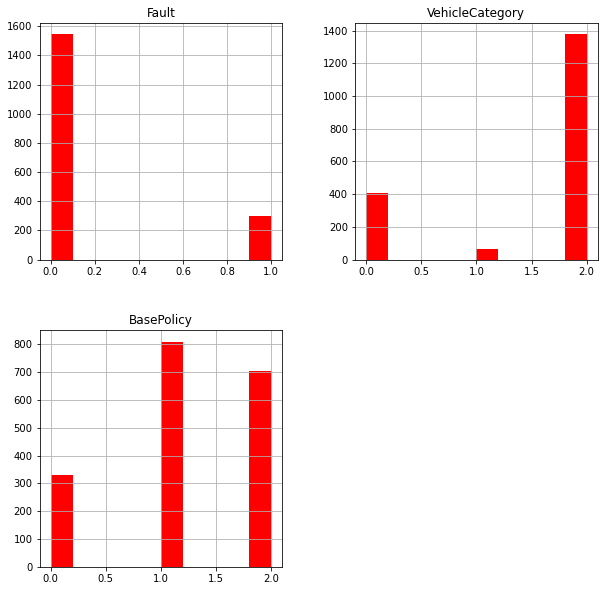

In [123]:
X[best].hist(figsize=(10,10),color='red')

### Cambio de espacio $\mathcal{X}_{[0,1]}$

In [124]:
sc = MinMaxScaler()
sc.fit(X[best])

MinMaxScaler()

In [125]:
X01 = pd.DataFrame(sc.transform(X[best]),columns=best)
X01[um+vart] = X[um+vart]

## Partición

In [126]:
Xt,Xv,yt,yv = train_test_split(X01[um+best],X[um+vart],test_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [127]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Xt[best],yt[vart[0]])

LinearDiscriminantAnalysis()

## Validación del modelo

In [128]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [129]:
St['y^'] = modelo.predict(Xt[best])
Sv['y^'] = modelo.predict(Xv[best])

St['proba'] = modelo.predict_proba(Xt[best])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [130]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.7124773960216998
0.7300850734725445


In [131]:
print(roc_auc_score(y_true=St[vart[0]],y_score=St['proba']))
print(roc_auc_score(y_true=Sv[vart[0]],y_score=Sv['proba']))

0.7508508298863815
0.7761805286356261


In [132]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[145 124]
 [ 35 249]]
[[390 264]
 [ 85 554]]
